In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Binance API parameters
traded_assets = ['ETH']#, 'ETH', 'ADA', 'DOGE']
stable_assets = ['USDT']
start_date = "Jan 01, 2021"
end_date = "Dec 31, 2021"
time_horizons = ['1hr']#, '12hr', '1wk']

# EMA parameters
alpha_values = []

# labeling parameters
trend_reversal_tresholds = []
change_tolerances = []
forward_terms = []

trend_reverse_factor = 0.3
change_tolerance = 1
forward_term = 10
alpha = 0.5
break_away_point = 2

In [3]:
for traded_asset in traded_assets:
    for stable_asset in stable_assets:
        for time_horizon in time_horizons:
            # for alpha_value in alpha_values:
            df = pd.read_csv(f"data/{traded_asset}_{stable_asset}_{time_horizon}_{alpha}_ema.csv")

In [4]:
df['close_ema'] = df['close'].ewm(alpha=0.5).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df = df#[4_780:5_000]
df.reset_index(drop=True, inplace=True)

In [6]:
def percentage_change(start_index, end_index, df):
    # Given two indicies, return the percentage change at the second index form the first index
    return 100 * (df.loc[end_index, 'close_ema'] - df.loc[start_index, 'close_ema']) / df.loc[start_index, 'close_ema']

In [7]:
def check_exit_short(first_index, second_index, forward_term, trend_reverse_factor, change_tolerance, df) -> list:
    """
        Checks whether the trend from first_index to second_index is broken, return True if there is a reversal
        returns the number of indexes to increase second_index by for the next index to check trend reversal from

        trend_reversal occurs when 
        * trend from second_index to second_index+(upto forward_term) < trend first_index to second_index
        second_index >= first_index + 1

        eg: first_index = 3, 
            second_index = 11, 
            trend from index 3 to 10 = 1.5 (% change), 
            forward_term = 10,
            trend_reversal_factor = 0.3,
            change_tolerance = 0.5

            anytime from index 11 to index 21 if the percentage change <= -0.45, then
            we conclude that the trend reverses at index 11

            in case there are hard turns to the other direction (down trend) in index 4, 5 or
            somewhere around index x, it might be due to the natural volatility of cryptocurrency market
            and the actual trend might be kept intact in later indices. For this reason, we check to see
            if the change from 3 to 11 is greater than a given change_tolerance (0.5) down.            
    """
    
    # the increase in closing price EMA from current candle to the next (eg: increase from time=14:00 -> 15:00)
    root_increase = percentage_change(start_index=first_index, end_index=second_index, df=df)

    current_change = root_increase
    next_point_index = second_index

    i = 0
    # for the totality of our forward term or until current change reverses to negative 
    while (i < forward_term) or (current_change < 0):
        # check if the current trend is kept for forward_term amount of time 
        next_point_index += 1

        # avoid 
        if next_point_index > len(df) - 1:
            break

        current_change = percentage_change(start_index=second_index, end_index=next_point_index, df=df)
        
        if current_change <= -(root_increase*trend_reverse_factor):
            if abs(percentage_change(start_index=first_index, end_index=second_index, df=df)) > change_tolerance:
                return [True, 0, 1]
        
        i += 1
        
    # if the change between the first_index and second_index is too much (mostly due to persistent change of price in the
    # preffered directoin), return the first_index + forward_term as the second index to figure out the new trend from 
    # because if the price has broken out of the trend then the algorithm will favor buy-and-hold strategy unless there is
    # a significant change in price in the other direction that will undi all the change since first_index
    if root_increase >= break_away_point:
        return [False, forward_term, 1]

    
    # return second_index + 1 because we want the second_index to be the next one for the new iteration 
    # second_index will be sent back to theis function with the next iteration to find the possible trend reversal starting 
    # at second_index
    return [False, 0, 1]

In [8]:
def check_exit_long(first_index, second_index, forward_term, trend_reverse_factor, change_tolerance, df) -> list:
    """
        Checks whether the trend from first_index to second_index is broken, return True if there is a reversal
        returns the number of indexes to increase second_index by for the next index to check trend reversal from

        trend_reversal occurs when 
        * trend from second_index to second_index+(upto forward_term) > trend first_index to second_index
        second_index >= first_index + 1

        eg: first_index = 3, 
            second_index = 11, 
            trend from index 3 to 10 = -1.5 (% change), 
            forward_term = 10,
            trend_reversal_factor = 0.3,
            change_tolerance = 0.5

            anytime from index 11 to index 21 if the percentage change >= 0.45, then
            we conclude that the trend reverses at index 11

            in case there are hard turns to the other direction (down trend) in index 4, 5 or
            somewhere around index x, it might be due to the natural volatility of cryptocurrency market
            and the actual trend might be kept intact in later indices. For this reason, we check to see
            if the change from 3 to 11 is greater than a given change_tolerance (0.5) down.            
    """
        
    root_decrease = percentage_change(start_index=first_index, end_index=second_index, df=df)

    current_change = root_decrease
    next_point_index = second_index
    
    i = 0
    while (i < forward_term) or (current_change > 0):
        # check if the current trend is kept for forward_term amount of time 
        next_point_index += 1

        if next_point_index > len(df)-1:
                break

        current_change = percentage_change(start_index=second_index, end_index=next_point_index, df=df)

        if current_change >= -(root_decrease*trend_reverse_factor):
            if abs(percentage_change(start_index=first_index, end_index=second_index, df=df)) > change_tolerance:
                return [True, 0, 1]
        
        i += 1
        
    # if the change between the first_index and second_index is too much (mostly due to persistent change of price in the
    # preffered directoin), return the first_index + forward_term as the second index to figure out the new trend from 
    # because if the price has broken out of the trend then the algorithm will favor buy-and-hold strategy unless there is
    # a significant change in price in the other direction that will undi all the change since first_index
    if root_decrease <= -break_away_point:
        return [False, forward_term, 1]
            
        
    # return second_index + 1 because we want the second_index to be the next one for the new iteration 
    # second_index will be sent back to theis function with the next iteration to find the possible trend reversal starting 
    # at second_index
    return [False, 0, 1]

In [9]:
# create initial position with ema
if df.loc[0, 'close_ema'] < df.loc[1, 'close_ema']:
    df.loc[0, 'position'] = 1
else:
    df.loc[0, 'position'] = 0

time_n = 0
time_n_1 = 1

while (time_n < len(df) - 1) and (time_n_1 < len(df) - 1):
    # if entry
    if df.loc[time_n, 'position'] == 1:
        # if in long, exit into short
        # unitl we get a trend reversal, we continue holding the position
    
        change_position = False

        while change_position == False:
            change_position, new_first_index_addition, new_second_index_addition = check_exit_long(
                first_index=time_n, 
                second_index=time_n_1, 
                forward_term=forward_term, 
                trend_reverse_factor=trend_reverse_factor, 
                change_tolerance=change_tolerance, 
                df=df
            )

            time_n += new_first_index_addition
            time_n_1 += new_second_index_addition
            # to avoid doubling and explosive growth of new_second_index_addition
            # new_second_index_addition = 1 

            if time_n_1 > len(df) - 1:
                break
        
        # enter new position (short)
        df.loc[time_n_1, 'position'] = 0

        # update indices to new position indices
        time_n = time_n_1
        time_n_1 += 1
    else:
        # if in short, exit into long
        # until we get a trend reversal, we continue holding the position
        change_position = False

        while change_position == False:
            change_position, new_first_index_addition, new_second_index_addition = check_exit_short(
                first_index=time_n, 
                second_index=time_n_1, 
                forward_term=forward_term, 
                trend_reverse_factor=trend_reverse_factor, 
                change_tolerance=change_tolerance, 
                df=df
            )

            time_n += new_first_index_addition
            time_n_1 += new_second_index_addition
            # to avoid doubling and explosive growth of new_second_index_addition
            # new_second_index_addition = 1
            if time_n_1 > len(df) - 1:
                break
            
        # enter new position
        df.loc[time_n_1, 'position'] = 1

        # update indices to new position indices
        time_n = time_n_1
        time_n_1 += 1

In [10]:
"""
long_utility: the utility value if stategy takes long at that price
"""
i = len(df) - 1
inflection_point_index = i

while i >= 0:
    if pd.isnull(df.loc[i, 'position']):
        df.loc[i, 'long_utility'] = df.loc[inflection_point_index, 'close_ema'] - df.loc[i, 'close_ema']
    else:
        inflection_point_index = i
        df.loc[i, 'long_utility'] = df.loc[inflection_point_index, 'close_ema'] - df.loc[i, 'close_ema']

    i -= 1

df.loc[len(df)-1, 'long_utility'] = 0 # to make the scale of the graph of long_utility equal wit the rest

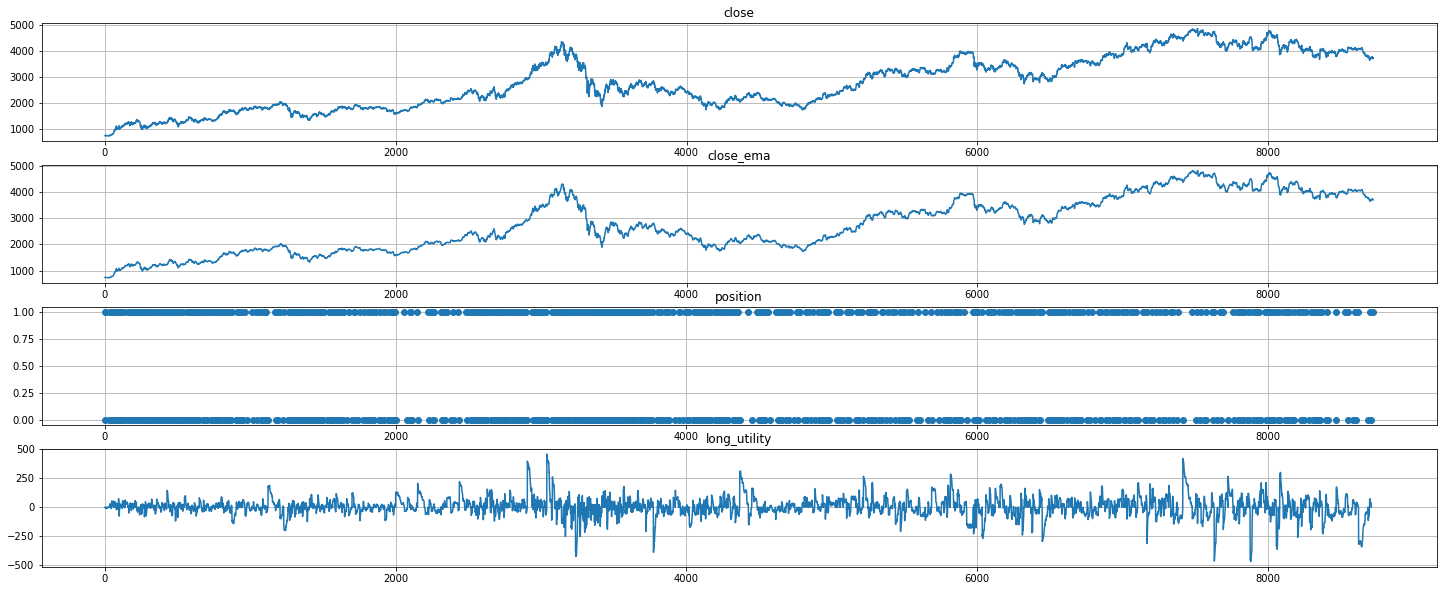

In [11]:
plt.figure(figsize=(25, 10))
plt.subplot(411)
plt.plot(df['close'])
plt.title('close')
plt.grid()

plt.subplot(412)
plt.plot(df['close_ema'])
plt.title('close_ema')
plt.grid()

plt.subplot(413)
plt.plot(df['position'], 'o')
plt.title('position')
plt.grid()

plt.subplot(414)
plt.plot(df['long_utility'])
plt.title('long_utility')
plt.grid()